# KNN
## -> removing stopwords, with stemming
## K = 19  
## Acc: 0.77125   
## F1: 0.7726708074534162

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict
from sklearn.metrics import classification_report,r2_score,recall_score,confusion_matrix

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB_Dataset.csv')
train_df.drop_duplicates(inplace = True)
df_sampled = train_df.sample(12000)
df_target = df_sampled['sentiment']
df_data = df_sampled.copy()
df_data.drop(columns='sentiment',inplace=True)

df_target.head()

25910    positive
5625     negative
3166     positive
9700     positive
47173    negative
Name: sentiment, dtype: object

Preprocessing

In [ ]:
df_data

,review
5986,"In this ""critically acclaimed psychological th..."
15913,This is the fifth von Trier film I have seen. ...
40624,"This was a very good PPV, but like Wrestlemani..."
21344,I can't comment on the accuracy of this produc...
43290,A made for television version of the Heart of ...
...,...
27498,The main problems of 'Saw' are related to the ...
21763,My house mate and I foolishly purchased the vi...
23637,"Maybe ""Presque Rien"" is not the best movie eve..."
31980,The story and the characters were some of the ...


In [5]:
import re
#Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

#Removes HTML syntaxes
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

#Removes URL data
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

df_data['review']=df_data['review'].apply(lambda z: remove_punctuations(z)).apply(lambda z: remove_html(z))
# Remove all the special characters
df_data['review']=df_data['review'].apply(lambda z: re.sub(r'\W', ' ', z))
# remove all single characters
df_data['review']=df_data['review'].apply(lambda z: re.sub(r'\s+[a-zA-Z]\s+', ' ', z))
# Remove single characters from the start
df_data['review']=df_data['review'].apply(lambda z: re.sub(r'\^[a-zA-Z]\s+', ' ', z)) 
# Substituting multiple spaces with single space
df_data['review']=df_data['review'].apply(lambda z: re.sub(r'\s+', ' ', z, flags=re.I))
# Removing prefixed 'br'
df_data['review']=df_data['review'].apply(lambda z: re.sub(r'^br\s+', '', z))
# if you want to turn reviews into lists. use this. (algorithm dependent)
#df_data['review']=df_data['review'].apply(lambda z: z.split())
#encode target to numeric
df_target = df_target.apply(lambda x: 1 if x == "positive" else 0)

In [6]:
df_target

25910    1
5625     0
3166     1
9700     1
47173    0
        ..
26942    1
23027    0
27628    1
47452    1
17476    1
Name: sentiment, Length: 12000, dtype: int64

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

#Apply CountVectorizer on text column

vectorizer = CountVectorizer(binary=True)

matrix = vectorizer.fit_transform(df_data["review"])

print("Vectorizer created {} features.".format(len(vectorizer.get_feature_names())))

df_data_countVectorized = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())
display(df_data_countVectorized)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Vectorizer created 82778 features.


,00,000,0000000000001,00015,001,002,00383042,007,007br,007s,...,édith,élan,étcother,ís,óli,über,übertrash,ýs,þorleifsson,þór
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re, string

#when running for the first time you need to activate this line for once.
nltk.download('stopwords')

#definition of stemming function
token_pattern = re.compile(r"(?u)\b\w\w+\b") # split on whitespace

def tokenize(text):
    my_stopwords = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    stems = []
    
    tokens = token_pattern.findall(text)
    for item in tokens:
        if item not in my_stopwords:
            stems.append(stemmer.stem(item))
    return stems

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
stem_vectorizer = TfidfVectorizer(tokenizer=tokenize, min_df=0.0015)
matrix = stem_vectorizer.fit_transform(df_data["review"])
matrix

<12000x6125 sparse matrix of type '<class 'numpy.float64'>'
	with 1017564 stored elements in Compressed Sparse Row format>

In [10]:
df_data_stemmed = pd.DataFrame(matrix.toarray(), columns=stem_vectorizer.get_feature_names())
display(df_data_stemmed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,10,100,1000,101,1010,10br,11,110,12,13,...,youngster,your,youth,youtub,youv,zani,zero,zombi,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


KNN

In [11]:
# Create train/test split
df_data_train, df_data_test, df_target_train, df_target_test = train_test_split(
    df_data_stemmed, df_target, test_size=0.2, random_state=42)

#for n_neighbors in range(3,21):#[1,2,3,4,5]:#1,2,3,4,5
#    knn_estimator = KNeighborsClassifier(n_neighbors)
#    knn_estimator.fit(df_data_train, df_target_train)
#    df_prediction = knn_estimator.predict(df_data_test)
#    print("k= {} acc: {} F1: {}".format(n_neighbors, accuracy_score(df_target_test, df_prediction), f1_score(df_target_test, df_prediction)))




In [12]:
from sklearn.model_selection import GridSearchCV
grid_params = {
    'n_neighbors': [19],
    'algorithm': ['auto','ball_tree','kd_tree','brute'],
    'metric': ['euclidean','cosine']

}
knn_estimator = KNeighborsClassifier()

estimator = GridSearchCV(knn_estimator,grid_params,cv=3)
estimator.fit(df_data_train, df_target_train)
print(estimator.best_estimator_)
print(estimator.best_score_)
print(estimator.best_params_)
final_estimator_knn = estimator.best_estimator_

KNeighborsClassifier(metric='euclidean', n_neighbors=19)
0.758125
{'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 19}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
6 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py", line 437, in _fit
    self._check_algorithm_metric()
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighb

k= 3 acc: 0.692 F1: 0.7118802619270347  
k= 4 acc: 0.6805 F1: 0.6591999999999999  
k= 5 acc: 0.7005 F1: 0.7191748710736052  
k= 6 acc: 0.7055 F1: 0.6943435391800725  
k= 7 acc: 0.714 F1: 0.7263157894736842  
k= 8 acc: 0.7105 F1: 0.7020072053525475  
k= 9 acc: 0.73 F1: 0.7403846153846154  
k= 10 acc: 0.7265 F1: 0.7193432529502308  
k= 11 acc: 0.739 F1: 0.7483124397299903  
k= 12 acc: 0.735 F1: 0.7304170905391659  
k= 13 acc: 0.7395 F1: 0.7489156626506023  
k= 14 acc: 0.7435 F1: 0.7378640776699029  
k= 15 acc: 0.7545 F1: 0.7615347255949491  
k= 16 acc: 0.7525 F1: 0.7468030690537084  
k= 17 acc: 0.7645 F1: 0.7701317715959004  
k= 18 acc: 0.76 F1: 0.7543500511770725  
k= 19 acc: 0.7635 F1: 0.7698296836982969  
k= 20 acc: 0.7605 F1: 0.7552376085845681  

# best performing K parameter is k= 19 with the metric euclidean

k= 19 acc: 0.7729166666666667 F1: 0.7797979797979797
0.7797979797979797


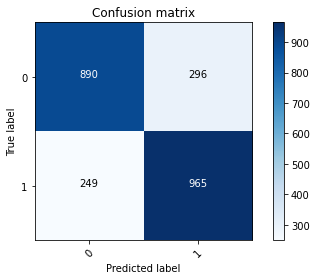

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np

knn_estimator = KNeighborsClassifier(n_neighbors=19, metric='euclidean')
knn_estimator.fit(df_data_train, df_target_train)
df_prediction = knn_estimator.predict(df_data_test)
print("k= {} acc: {} F1: {}".format(19, accuracy_score(df_target_test, df_prediction), f1_score(df_target_test, df_prediction)))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
cnf_matrix = confusion_matrix(df_target_test, df_prediction)
print(f1_score(df_target_test, df_prediction))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=[0,1])